In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

C:\Users\New\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
C:\Users\New\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Reading in data
# ==============================================================================
solar0=pd.read_csv('Solar 0.csv')

In [3]:
#Converting to Datetime objects
# ==============================================================================
solar0['datetime']=pd.to_datetime(solar0['datetime'], format='%Y-%m-%d %H:%M:%S')
solar0= solar0.set_index('datetime')
solar0= solar0.asfreq('H')

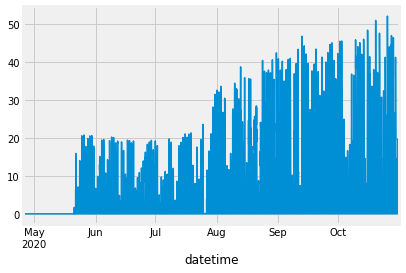

In [4]:
solar0['series_value'].plot()

In [37]:
#Split Train-Val for Solar0
# ==============================================================================
start_train='2020-06-01 00:00'
end_train='2020-09-01 00:00'
start_val='2020-09-01 01:00'
end_val='2020-09-30 23:00'
start_test='2020-10-01 00:00'

solar0train=solar0.loc[start_train:end_train, :]
solar0val=solar0.loc[start_val:end_val, :]
solar0test=solar0.loc[start_test:, :]

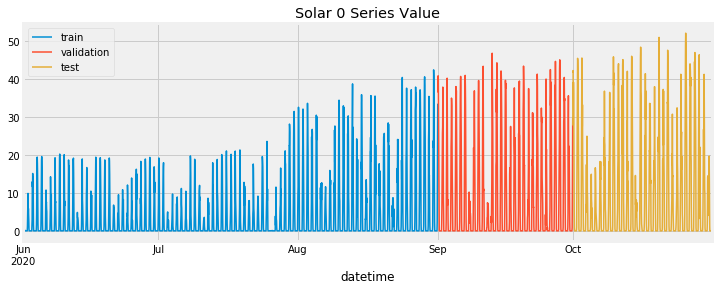

In [48]:
# Plot time series
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
solar0train['series_value'].plot(ax=ax, label='train')
solar0val['series_value'].plot(ax=ax, label='validation')
solar0test['series_value'].plot(ax=ax, label='test')
ax.set_title('Solar 0 Series Value')
ax.legend();

In [39]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags = 24
                )

forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-09-23 18:03:07 
Last fit date: None 
Skforecast version: 0.4.3 

In [40]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters

param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
    }
lags_grid = [24, 48, 72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = solar0.loc[:end_val, 'series_value'],
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(solar0train)),
                        lags_grid          = lags_grid,
                        param_grid         = param_grid,
                        steps              = 36,
                        )

Number of models compared: 48


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:   8%|███                                  | 1/12 [00:00<00:04,  2.62it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:03,  2.65it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  25%|█████████▎                           | 3/12 [00:01<00:03,  2.71it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  33%|████████████▎                        | 4/12 [00:01<00:03,  2.19it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  42%|███████████████▍                     | 5/12 [00:02<00:03,  2.30it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:02<00:03,  1.88it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:03<00:02,  2.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:03<00:01,  2.20it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:03<00:01,  2.41it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:04<00:00,  2.25it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:04<00:00,  2.42it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:   8%|███                                  | 1/12 [00:00<00:03,  3.30it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:04,  2.44it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  25%|█████████▎                           | 3/12 [00:01<00:03,  2.50it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  33%|████████████▎                        | 4/12 [00:01<00:04,  1.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  42%|███████████████▍                     | 5/12 [00:02<00:03,  2.19it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:03<00:03,  1.72it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:03<00:02,  2.04it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:03<00:01,  2.19it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:04<00:01,  2.43it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:04<00:00,  2.21it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:04<00:00,  2.35it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:   8%|███                                  | 1/12 [00:00<00:03,  2.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  17%|██████▏                              | 2/12 [00:01<00:05,  1.82it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  25%|█████████▎                           | 3/12 [00:01<00:04,  2.11it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  33%|████████████▎                        | 4/12 [00:02<00:04,  1.73it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  42%|███████████████▍                     | 5/12 [00:02<00:03,  1.95it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:03<00:04,  1.49it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:03<00:02,  1.81it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:04<00:02,  1.84it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:04<00:01,  2.09it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:05<00:01,  1.89it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:05<00:00,  2.05it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:   8%|███                                  | 1/12 [00:00<00:03,  3.52it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  17%|██████▏                              | 2/12 [00:00<00:03,  2.92it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  25%|█████████▎                           | 3/12 [00:01<00:03,  2.96it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  33%|████████████▎                        | 4/12 [00:01<00:03,  2.60it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  42%|███████████████▍                     | 5/12 [00:01<00:02,  2.75it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  50%|██████████████████▌                  | 6/12 [00:02<00:02,  2.33it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  58%|█████████████████████▌               | 7/12 [00:02<00:01,  2.69it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  67%|████████████████████████▋            | 8/12 [00:02<00:01,  2.68it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  75%|███████████████████████████▊         | 9/12 [00:03<00:01,  2.94it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  83%|██████████████████████████████      | 10/12 [00:03<00:00,  2.87it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop param_grid:  92%|█████████████████████████████████   | 11/12 [00:03<00:00,  3.09it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 2209
Number of observations used for backtesting: 1593
    Number of folds: 45
    Number of steps per fold: 36
    Last fold only includes 9 observations

Data partition in fold: 0
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-26 15:00:00 -- 2020-07-28 02:00:00
Data partition in fold: 1
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-28 03:00:00 -- 2020-07-29 14:00:00
Data partition in fold: 2
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-29 15:00:00 -- 2020-07-31 02:00:00
Data partition in fold: 3
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-07-31 03:00:00 -- 2020-08-01 14:00:00
Data partition in fold: 4
    Training:   2020-04-25 14:00:00 -- 2020-07-26 14:00:00
    Validation: 2020-08-01 15:00:00 -- 202


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [00:22<00:00,  5.54s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 52.75440681833216



In [41]:
# Results of grid search
# ==============================================================================
results_grid.head(10)

,lags,params,metric,learning_rate,max_depth,n_estimators
18,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",52.754407,0.10,3.0,100.0
31,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",53.278354,0.10,3.0,500.0
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",54.258045,0.10,3.0,500.0
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",56.029608,0.10,5.0,100.0
29,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",56.334936,0.01,10.0,500.0
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",57.010431,0.10,3.0,100.0
30,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",57.106053,0.10,3.0,100.0
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",57.375870,0.01,3.0,500.0
17,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",57.691658,0.01,10.0,500.0
33,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",58.125508,0.10,5.0,500.0


In [42]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y          = solar0['series_value'],
    initial_train_size = len(solar0.loc[:end_val]),
    fixed_train_size   = False,
    steps      = 36,
    refit      = False,
    metric     = 'mean_squared_error',
    verbose    = False 
    )

print(f"Backtest error: {metric}")

Backtest error: 52.32884504645814


In [43]:
# Predictions
# ==============================================================================
predictions

,pred
2020-10-01 00:00:00,26.777892
2020-10-01 01:00:00,36.041619
2020-10-01 02:00:00,36.322456
2020-10-01 03:00:00,29.882328
2020-10-01 04:00:00,23.307254
...,...
2020-10-31 19:00:00,0.268392
2020-10-31 20:00:00,1.347489
2020-10-31 21:00:00,7.289726
2020-10-31 22:00:00,14.574250


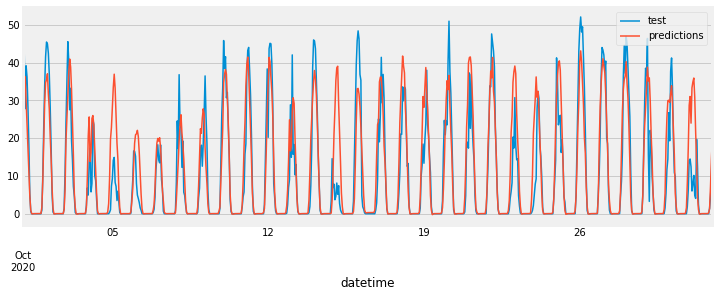

In [44]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
solar0test['series_value'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

In [45]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))

In [46]:
solar0test=solar0test.dropna()
solar0train=solar0train.dropna()

In [47]:
mean_absolute_scaled_error(solar0test.reset_index()['series_value'],predictions.reset_index()['pred'],solar0train.reset_index()['series_value'])

2.081751078957667

In [ ]:
# Forecasting Solar with Weather Variable
# ==============================================================================

In [49]:
#Reading in data
# ==============================================================================
weather=pd.read_csv('ERA5_Weather_Data_Monash.csv')

In [50]:
weather

,datetime (UTC),"coordinates (lat,lon)",model (name),model elevation (surface),utc_offset (hrs),temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
0,2010-01-01 00:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.26,16.39,2.60,101046.38,0.89,287.01,408.35,1.00
1,2010-01-01 01:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.67,16.29,2.91,101037.96,0.86,360.79,411.02,1.00
2,2010-01-01 02:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.16,15.89,3.26,101017.26,0.87,291.54,410.67,1.00
3,2010-01-01 03:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.46,15.33,3.17,101022.56,0.82,357.11,410.95,1.00
4,2010-01-01 04:00:00,"(-37.91, 145.13)",era5,69.59,10.0,18.53,15.11,2.95,100940.03,0.80,459.91,410.00,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100052,2021-05-31 20:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.31,3.28,4.91,102033.73,0.71,0.00,278.11,0.93
100053,2021-05-31 21:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.15,3.16,4.63,102033.49,0.71,0.00,277.98,1.00
100054,2021-05-31 22:00:00,"(-37.91, 145.13)",era5,69.59,10.0,8.72,3.31,5.29,102069.84,0.69,8.99,281.65,1.00
100055,2021-05-31 23:00:00,"(-37.91, 145.13)",era5,69.59,10.0,9.83,3.88,5.60,102077.12,0.66,80.46,296.20,1.00


In [53]:
#Converting to Datetime objects
# ==============================================================================
weather['datetime (UTC)']=pd.to_datetime(weather['datetime (UTC)'], format='%Y-%m-%d %H:%M:%S')
weather= weather.set_index('datetime (UTC)')
weather= weather.asfreq('H')

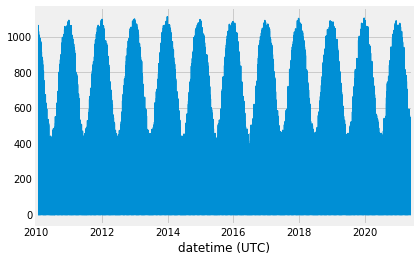

In [55]:
weather['surface_solar_radiation (W/m^2)'].plot()

In [67]:
weathertrain=weather.loc[start_train:end_train, :]
weatherval=weather.loc[start_val:end_val, :]
weathertest=weather.loc[start_test:'2020-10-31 23:00']

In [72]:
solar_radiation=weather['surface_solar_radiation (W/m^2)'].loc[start_train:'2020-10-31 23:00']

In [77]:
exog_variables=[solar_radiation]